## Домашнее задание : "Обучение с подкреплением"

ФИО: Сим Роман Дмитриевич

# Задание

Следуя шаблонам функций реализуйте алгоритм Policy iteration.
Протестируйте его с помощью функции __evaluate_policy__.
Попробуйте разные значение для gamma и сравните результаты.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install atari-py
!python -m atari_py.import_roms drive/MyDrive/Roms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
copying breakout.bin from drive/MyDrive/Roms/Breakout - Breakaway IV (Paddle) (1978) (Atari, Brad Stewart - Sears) (CX2622 - 6-99813, 49-75107) ~.bin to /usr/local/lib/python3.8/dist-packages/atari_py/atari_roms/breakout.bin


In [ ]:
%pip install ale-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.2 MB/s 


In [ ]:
from ale_py import ALEInterface

ale = ALEInterface()

In [ ]:
from ale_py.roms import Breakout

ale.loadROM(Breakout)

/usr/local/lib/python3.8/dist-packages/ale_py/roms/__init__.py:119: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`. For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  path = _resolve_rom(name)


In [ ]:
import torch
import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm.notebook import tqdm
import cv2

In [ ]:
import gym
os.environ["SDL_VIDEODRIVER"] = "dummy"

env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')

env.reset()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `reset()` method was expecting a nump

In [ ]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


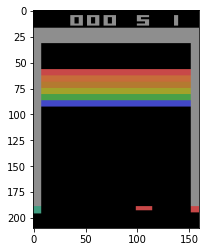

In [ ]:
plt.imshow(env.render())

In [ ]:
def preprocess(screen, width=env.observation_space.shape[0], height=env.observation_space.shape[1], targetWidth=84, targetHeight=84):
	screen = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)
	screen = screen[20:300, 0:200]  # crop off score
	screen = cv2.resize(screen, (targetWidth, targetHeight))
	screen = screen.reshape(targetWidth, targetHeight) / 255
	return screen

In [ ]:
env.reset()
new_state, _, _, _ = env.step(1)

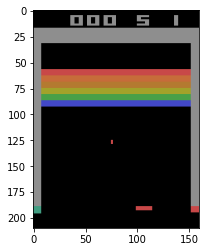

In [ ]:
plt.imshow(new_state)

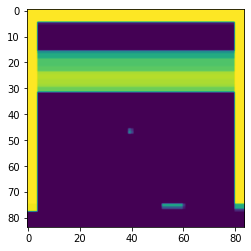

In [ ]:
plt.imshow(preprocess(new_state))

## save gifs

In [ ]:
import imageio

In [ ]:
def save_gif(state_list, gif_name):
    imageio.mimsave(
    f"drive/MyDrive/atari/{gif_name}.gif",
    state_list,
    fps=24,
)

In [ ]:
def make_game(env, atari_nn, gif_name, max_repeat=2000):
    state = env.reset()
    done = False
    renders = []
    i = 0
    repeat_cnt = 0
    env.step(1)

    for i in tqdm(range(max_repeat)):
        renders.append(env.render(mode='rgb_array'))
        state = torch.from_numpy(state).float()
        state = torch.moveaxis(state, 2, 0)
        action = atari_nn.get_next_state(state)
        if action is None:
            next_state, reward, done, _ = env.step(np.random.randint(0, 4))
            state = next_state
            continue

        next_state, reward, done, _ = env.step(action)
        if next_state == state:
            repeat_cnt += 1
        if done:
            break
        state = next_state
        i += 1
    save_gif(renders, gif_name)
    return renders

## AtariNet

In [ ]:
class AtariNet(torch.nn.Module):
    def __init__(self, gamma=0.9, loss_coeff=0.4, entropy_coeff=0.6):
        super(AtariNet, self).__init__()
        self.gamma = gamma
        self.loss_coeff = loss_coeff
        self.entropy_coeff = entropy_coeff
        self.action_probs = []
        self.rewards = []

        self.convLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(4, 8, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.convLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 16, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.convLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        # 27*40*32

        self.fc1 = torch.nn.Linear(2048, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.fc3 = torch.nn.Linear(100, 4)

    def forward(self, x):
        x = self.convLayer1(x)
        x = self.convLayer2(x)
        x = self.convLayer3(x)
        x = x.flatten()
        x = torch.nn.ReLU()(self.fc1(x))
        x = torch.nn.ReLU()(self.fc2(x))
        x = torch.nn.Softmax()(self.fc3(x))
        return x
    
    def get_next_state(self, env_state):
        env_state = Variable(env_state)
        prob = self.forward(env_state)

        prob = torch.distributions.Categorical(prob) 
        action = prob.sample()
        self.action_probs.append(prob.log_prob(action))

        return action.item()

    def get_loss(self, rewards):
        policy_losses = torch.zeros(len(rewards))
    
        for i, log_prob, reward in zip(np.arange(len(rewards)), self.action_probs, rewards):
            policy_losses[i] = -log_prob*reward

        m = torch.distributions.Categorical(
        logits=torch.cat([x.view(-1) for x in self.action_probs]))
        entropy_loss = (-0.05 * m.entropy()).mean()
        return self.loss_coeff*policy_losses.sum() + self.entropy_coeff*entropy_loss

    def get_discounted_reward(self):

        discounted_reward = np.zeros_like(self.rewards)

        mediate_sum = 0
        for t in reversed(range(len(self.rewards))):
            mediate_sum = mediate_sum * self.gamma + self.rewards[t]
            discounted_reward[t] = mediate_sum
        return discounted_reward
    


## train_function

In [ ]:
def train(env, atari_nn, num_episodes=10, repeat_number = 2000):
    max_reward = -999
    batch_size = 5
    learning_rate = 0.01
    optimizer = torch.optim.Adam(atari_nn.parameters(), lr=learning_rate)
    episode_durations = []
    state_pool = []
    steps = 0

    for e in range(num_episodes):
        renders = []
        states = []
        state = env.reset()
        state, reward, done, info = env.step(1)
        renders.append(env.render())
        state = torch.from_numpy(state).float()
        if state.__class__ != np.ndarray:
                state = state.numpy()
        state = torch.from_numpy(preprocess(state)).float().unsqueeze(0)
        states.append(state)
        for i in range(3):
          state, reward, done, info = env.step(np.random.randint(0, 4))
          renders.append(env.render())
          state = torch.from_numpy(state).float()
          if state.__class__ != np.ndarray:
                  state = state.numpy()
          state = torch.from_numpy(preprocess(state)).float().unsqueeze(0)
          states.append(state)
        lives = 5

        for t in tqdm(range(repeat_number)):
            renders.append(env.render())
            action = atari_nn.get_next_state(torch.cat(states, 0))
            
            next_state, reward, done, info = env.step(action)
            if info['lives'] < lives:
                lives = info['lives']
                next_state, _, done, info = env.step(1)
            atari_nn.rewards.append(reward)
            state = next_state
            state = torch.from_numpy(preprocess(state)).float().unsqueeze(0)
            del states[0]
            states.append(state)
            if done:
                break
        episode_durations.append(t)

        if sum(atari_nn.rewards) > max_reward:
          max_reward = sum(atari_nn.rewards)
          save_gif(renders, f'best')
        if e%5 == 0:
          save_gif(renders, f'game_{e}')

        optimizer.zero_grad()
        loss = atari_nn.get_loss(atari_nn.get_discounted_reward())
        loss.backward()
            
        optimizer.step()

        # clear_output()
        print(f'Iteration: {e}; rewards={sum(atari_nn.rewards)}, loss={loss.item()}')
        atari_nn.rewards = []
        atari_nn.action_probs = []

    return episode_durations


In [ ]:
net = AtariNet(loss_coeff=0.9, entropy_coeff=1.2)


In [ ]:
episode_durations = train(env, net, num_episodes=50)